In [2]:
import numpy as np
import matplotlib.pyplot as plt
from desc.plotting import plot_coils
from desc.coils import (
    CoilSet,
    FourierPlanarCoil,
    SplineXYZCoil,
    MixedCoilSet,
    initialize_modular_coils,
    initialize_saddle_coils,
)

In [5]:
### simple axisymetric coils

In [19]:
###### Background Straight Field
R_coil = 1.3
I = 1e7
N = 2
# pos = np.array([-1,0,1])
pos = np.linspace(0, 2 * np.pi, N)
coils = []

for p in pos:
    c = FourierPlanarCoil(
        current=I,
        center=[10, p, 0],
        normal=[0, 1, 0],
        r_n=R_coil,
        modes=[0],
    )
    c.change_resolution(N=100)
    coils += [c]

In [21]:
coilset = MixedCoilSet(coils)

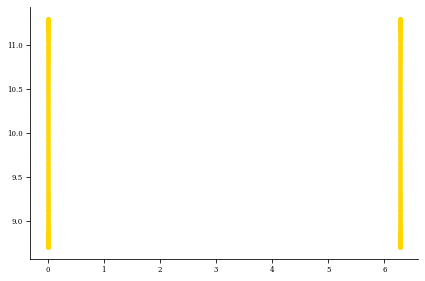

In [39]:
## plot coils

coil_data = coilset.compute(["X", "Y", "Z"])

for i in coil_data:
    x = i["X"]
    y = i["Y"]
    z = i["Z"]
    plt.plot(y, x, ".", color="gold")

In [25]:
## field on axis

Text(0, 0.5, '|B|')

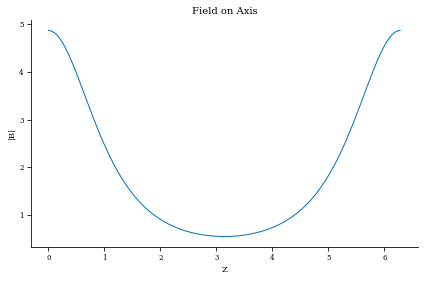

In [37]:
plt.title(r"Field on Axis")
yaxis = np.linspace(0, 2 * np.pi, 1000)
zaxis = np.zeros_like(yaxis)
xaxis = np.ones_like(zaxis) * 10

B = coilset.compute_magnetic_field(np.array([xaxis, yaxis, zaxis]).T, basis="xyz")
modB = np.linalg.norm(B, axis=-1)
plt.plot(yaxis, modB)
plt.xlabel("Z")
plt.ylabel("|B|")

In [35]:
modB.max() / modB.min()

np.float64(9.018821955886395)

In [141]:
from desc.grid import ConcentricGrid, Grid


def chebygrid(N_grid):
    return np.concatenate(
        (
            [0],
            (-np.cos((2 * np.arange(N_grid) + 1) * np.pi / (2 * N_grid)) + 1) * np.pi,
            [2 * np.pi],
        )
    )


def grid_gen(L_grid, M_grid, N_grid, node_pattern="jacobi"):
    LMnodes = ConcentricGrid(L=L_grid, M=M_grid, N=0, node_pattern=node_pattern).nodes[
        :, :2
    ]
    Nnodes = chebygrid(N_grid)
    lm = np.tile(LMnodes, (Nnodes.size, 1))
    n = np.tile(Nnodes.reshape(-1, 1), (1, LMnodes.shape[0])).reshape(-1, 1)
    nodes = np.concatenate((lm, n), axis=1)

    # RG: weights and spacing defined here
    # just for the sake of compilation. Must be checked
    weights = np.ones(nodes.shape[0])
    spacing = np.ones_like(nodes)

    spacing[1:, 1] = np.diff(nodes[:, 1])
    spacing[1:, 2] = np.diff(nodes[:, 2])

    return Grid(nodes, spacing=spacing, weights=weights)

In [143]:
# grid = grid_gen(10, 40, 40)

In [20]:
### MGRID
# coilset.save_mgrid('simple_mirror_MR_9',Rmin = 0,Rmax = 1,Zmin = 0, Zmax = 2*np.pi)

In [41]:
coilset.save_in_makegrid_format("simple_coils_MR_9.coils")

In [26]:
coilset

MixedCoilSet at 0x10801c980 (name=, with 2 submembers)

In [ ]:
#### SMOLA Coils

In [8]:
def hellical_coil(
    N=100,
    zrange=[0, 1],
    radius=1,
    twists=10,
    handedness="left",
    leads=False,
    lead_offset=10,
):
    N_lead = 1000

    z_start = zrange[0]
    z_end = zrange[1]

    # Parametric coordinate
    theta = np.linspace(0, 2 * np.pi * twists, N * twists)
    y = np.linspace(z_start, z_end, N * twists)

    # Handedness control
    if handedness == "right":
        angle = theta
        switch = -1
    elif handedness == "left":
        angle = theta + np.pi
        switch = 1

    else:
        raise ValueError("handedness must be 'right' or 'left'")

    # Helix coordinates
    x = radius * np.cos(angle)
    z = radius * np.sin(angle)

    xyz = np.transpose([x, y, z])[::-1]

    if leads:
        # Lead 1: straight in -x from y_end
        x_lead1 = np.linspace(x[-1], x[-1] - switch * lead_offset + radius, N_lead)
        y_lead1 = np.full(N_lead, z_end)
        z_lead1 = np.full(N_lead, z[-1])
        xyz_lead1 = np.stack([x_lead1, y_lead1, z_lead1], axis=-1)

        # Lead 2: straight in -x from y_start
        x_lead2 = np.linspace(x[0], x[0] - switch * lead_offset + radius, N_lead)
        y_lead2 = np.full(N_lead, z_start)
        z_lead2 = np.full(N_lead, z[0])
        xyz_lead2 = np.stack([x_lead2, y_lead2, z_lead2], axis=-1)

        # Lead 3: connecting lead1 and lead2

        if switch == 1:
            theta = np.linspace(np.pi / 2, 3 * np.pi / 2, N_lead)
        if switch == -1:
            theta = np.linspace(-np.pi / 2, np.pi / 2, N_lead)

        r_semi = (np.abs(z_end) + np.abs(z_start)) / 2
        x_lead3 = r_semi * np.cos(theta) * 5 - switch * lead_offset
        y_lead3 = r_semi * np.sin(theta)
        z_lead3 = np.full(N_lead, 0)
        xyz_lead3 = np.stack([x_lead3, y_lead3, z_lead3], axis=-1)

        return np.concatenate([xyz, xyz_lead1, xyz_lead3, xyz_lead2[::-1]], axis=0)

    else:

        return xyz

In [10]:
hr = 0.172 / 2
pr = 0.375 / 2
Ih = 26 * 500  # Ampes
Ib = 90 * 500  # Ampes
start = 1.68 + 0.18

gc_shift = 1

## test
method = "linear"
X, Y, Z = hellical_coil(
    N=1000, zrange=[start, start + 2.16], radius=hr, twists=12, handedness="left"
).T
coil1 = SplineXYZCoil(Ih * gc_shift, X, Y, Z, method=method)
X, Y, Z = hellical_coil(
    N=1000, zrange=[start, start + 2.16], radius=hr, twists=12, handedness="right"
).T
coil2 = SplineXYZCoil(-Ih * gc_shift, X, Y, Z, method=method)

from desc.coils import CoilSet

coilset = CoilSet([coil1, coil2])

Text(0, 0.5, '|B|')

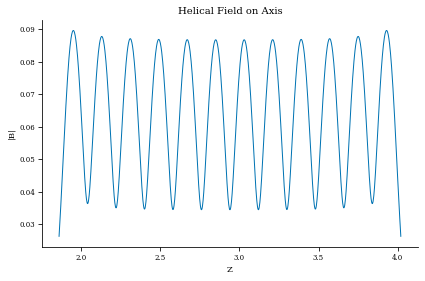

In [12]:
plt.title(r"Helical Field on Axis")
yaxis = np.linspace(start, start + 2.16, 1000)
zaxis = np.zeros_like(yaxis)
xaxis = np.ones_like(zaxis) * 0

B = coilset.compute_magnetic_field(np.array([xaxis, yaxis, zaxis]).T, basis="xyz")
modB = np.linalg.norm(B, axis=-1)
plt.plot(yaxis, modB)
plt.xlabel("Z")
plt.ylabel("|B|")

In [14]:
###### Background Straight Field
R_coil = pr
# pos = np.array([-1,0,1])
pos = np.linspace(start, start + 2.16, 12)
coils = []

for p in pos:
    c = FourierPlanarCoil(
        current=Ib * gc_shift,
        center=[0, p, 0],
        normal=[0, 1, 0],
        r_n=R_coil,
        modes=[0],
    )
    c.change_resolution(N=100)
    coils += [c]

In [16]:
coils += [coil1, coil2]
from desc.coils import MixedCoilSet

coilset = MixedCoilSet(coils)

Text(0, 0.5, '|B|')

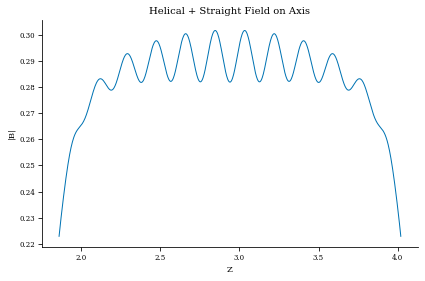

In [18]:
plt.title(r"Helical + Straight Field on Axis")
yaxis = np.linspace(start, start + 2.16, 1000)
zaxis = np.zeros_like(yaxis)
xaxis = np.ones_like(zaxis) * 0

B = coilset.compute_magnetic_field(np.array([xaxis, yaxis, zaxis]).T, basis="xyz")
modB = np.linalg.norm(B, axis=-1)
plt.plot(yaxis, modB)
plt.xlabel("Z")
plt.ylabel("|B|")

In [20]:
### Plasma formation coils
pos_g = np.linspace(0.2, 0.4, 2)
## 7cm VV
Ig = 90 * 1.8 * 500 * gc_shift  # Ampes
R_coil_g = 0.10

### "Smoothing" coils -- lifts B - well
pos_s = np.array([0.6, 0.8, 1.26, 1.46])
Is = 90 * 250 * gc_shift  # Ampes
R_coil_s = 0.375 * 1.5

In [22]:
coils_gun = []

for p in pos_g:
    c = FourierPlanarCoil(
        current=Ig,
        center=[0, p, 0],
        normal=[0, 1, 0],
        r_n=R_coil_g,
        modes=[0],
    )
    c.change_resolution(N=100)
    coils_gun += [c]

coils_large = []

for p in pos_s:
    c = FourierPlanarCoil(
        current=Is,
        center=[0, p, 0],
        normal=[0, 1, 0],
        r_n=R_coil_s,
        modes=[0],
    )
    c.change_resolution(N=100)
    coils_large += [c]

In [24]:
coils_large += [coils_gun]
coils_large += [coils]
coilset = MixedCoilSet(coils_large)

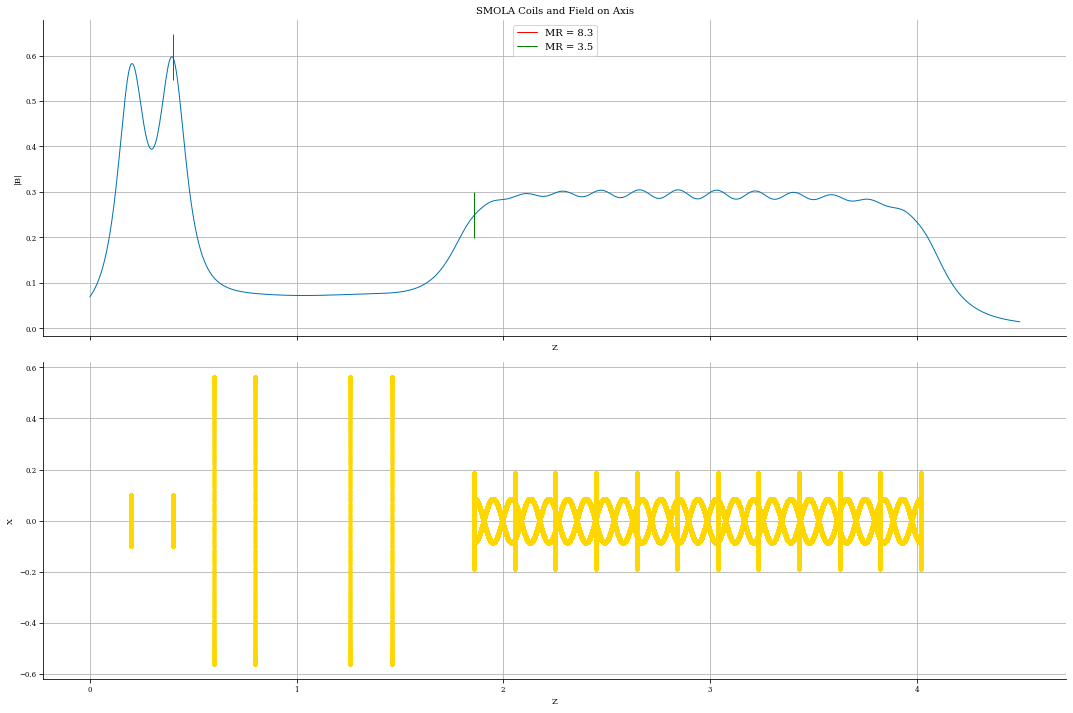

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

axs[0].set_title(r"SMOLA Coils and Field on Axis")

yaxis = np.linspace(0, 4.5, 1000)
zaxis = np.zeros_like(yaxis)
xaxis = np.ones_like(zaxis) * 0

B = coilset.compute_magnetic_field(np.array([xaxis, yaxis, zaxis]).T, basis="xyz")
modB = np.linalg.norm(B, axis=-1)
axs[0].plot(yaxis, modB)


### MR
# B at end of gun
B = coilset.compute_magnetic_field(np.array([0, 0.4, 0]).T, basis="xyz")
Bg = np.linalg.norm(B, axis=-1)

# min in central chamber
yaxis = np.linspace(0.05, 2, 1000)
zaxis = np.zeros_like(yaxis)
xaxis = np.ones_like(zaxis) * 0
B = coilset.compute_magnetic_field(np.array([xaxis, yaxis, zaxis]).T, basis="xyz")
Bmod = np.linalg.norm(B, axis=-1)
Bmin = np.min(Bmod)

# max B at the start of the transport region
B = coilset.compute_magnetic_field(np.array([0, start, 0]).T, basis="xyz")
Bt = np.linalg.norm(B, axis=-1)

gun_mr = Bg / Bmin
transport_mr = Bt / Bmin


axs[0].set_ylabel("|B|")
axs[0].set_xlabel("Z")
axs[0].grid()
axs[0].set_ylabel("|B|")
axs[0].vlines(
    0.4, Bg - 0.05, Bg + 0.05, color="red", label="MR = {:.1f}".format((gun_mr[0]))
)

axs[0].vlines(
    start,
    Bt - 0.05,
    Bt + 0.05,
    color="green",
    label="MR = {:.1f}".format((transport_mr[0])),
)
axs[0].legend(loc="upper center")


coil_data = coilset.compute(["X", "Y", "Z"])

for i in coil_data:
    x = i["X"]
    y = i["Y"]
    z = i["Z"]
    axs[1].plot(y, x, ".", color="gold")
axs[1].set_xlabel("Z")
axs[1].set_ylabel("X")
axs[1].grid()

In [28]:
coilset.save_in_makegrid_format("smola_coils_unscaled.coils")